In [1]:
import paddle
import paddle.nn as nn

In [20]:
class Conv2D(nn.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
    weight_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0)),
    bias_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=0.0))):
        super(Conv2D, self).__init__()
        self.weight = paddle.create_parameter(shape=[out_channels, in_channels, kernel_size, kernel_size], dtype='float32', attr=weight_attr)
        self.bias = paddle.create_parameter(shape=[out_channels, 1], dtype='float32', attr=bias_attr)
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels

    def single_forward(self, X, weight):
        new_X = paddle.zeros([X.shape[0], X.shape[1]+2*self.padding, X.shape[2]+2*self.padding])
        new_X[:, self.padding:X.shape[1]+self.padding, self.padding:X.shape[2]+self.padding] = X 
        u, v = weight.shape 
        output_w = (new_X.shape[1] - u) // self.stride + 1
        output_h = (new_X.shape[2] - v) // self.stride + 1
        output = paddle.zeros([X.shape[0], output_w, output_h])
        for i in range(0, output.shape[1]):
            for j in range(0, output.shape[2]):
                output[:, i, j] = paddle.sum(new_X[:, self.stride*i:self.stride*i+u, self.stride*j:self.stride*j+v]*weight, axis=[1,2])
        return output 

    def multi2single_forward(self, inputs, weight, b):
        return paddle.sum(paddle.stack([self.single_forward(inputs[:, i, :, :], weight[i]) for i in range(self.in_channels)], axis=1), axis=1) + b

    def multi2multi_forward(self, inputs, weight, bias):
        return paddle.stack([self.multi2single_forward(inputs, w, b) for w, b in zip(weight, bias)], axis=1)

    def forward(self, inputs):
        return self.multi2multi_forward(inputs, self.weight, self.bias)

In [3]:
class Pool2D(nn.Layer):
    def __init__(self, size=(2,2), mode='max', stride=1):
        super(Pool2D, self).__init__()
        self.mode = mode 
        self.h, self.w = size 
        self.stride = stride 

    def forward(self, x):
        output_w = (x.shape[2] - self.w) // self.stride + 1
        output_h = (x.shape[3] - self.h) // self.stride + 1
        output = paddle.zeros([x.shape[0], x.shape[1], output_w, output_h])
        for i in range(output.shape[2]):
            for j in range(output.shape[3]):
                if self.mode == 'max':
                    output[:, :, i, j] = paddle.max(x[:, :, self.stride*i:self.stride*i+self.w, self.stride*j:self.stride*j+self.h], axis=[2,3])
                elif self.mode == 'avg':
                    output[:, :, i, j] = paddle.mean(x[:, :, self.stride*i:self.stride*i+self.w, self.stride*j:self.stride*j+self.h], axis=[2,3])
        return output

In [5]:
import json
import gzip

train_set, dev_set, test_set = json.load(gzip.open('mnist.json.gz'))
train_images, train_labels = train_set[0][:1000], train_set[1][:1000]
dev_images, dev_labels = dev_set[0][:200], dev_set[1][:200]
test_images, test_labels = test_set[0][:200], test_set[0][:200]
train_set, dev_set, test_set = [train_images, train_labels], [dev_images, dev_labels], [test_images, test_labels]
print('Length of train/dev/test set:{}/{}/{}'.format(len(train_set[0]), len(dev_set[0]), len(test_set[0])))

Length of train/dev/test set:1000/200/200


The number in the picture is 5


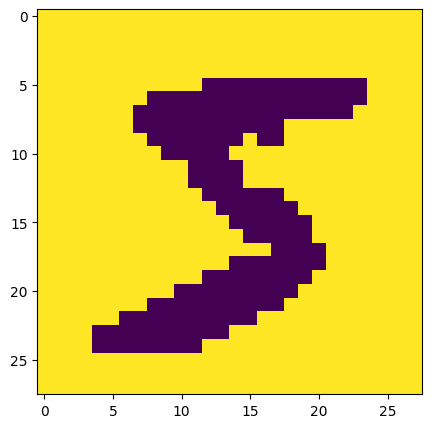

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image, label = train_set[0][0], train_set[1][0]
image, label = np.array(image).astype('float32'), int(label)
image = np.reshape(image, [28,28])
image = Image.fromarray(image.astype('uint8'), mode='L')
print("The number in the picture is {}".format(label))
plt.figure(figsize=(5, 5))
plt.imshow(image)

In [9]:
from paddle.vision.transforms import Compose, Resize, Normalize 

transforms = Compose([Resize(32), Normalize(mean=[127.5], std=[127.5], data_format='CHW')])

In [10]:
import random
import paddle.io as io 

class MNISTDataset(io.Dataset):
    def __init__(self, dataset, transforms, mode='train'):
        self.mode = mode
        self.transforms = transforms 
        self.dataset = dataset
        self.index_list = list(range(len(self.dataset[0])))

    def __getitem__(self, idx):
        idx = self.index_list[idx]
        image, label = self.dataset[0][idx], self.dataset[1][idx]
        image, label = np.array(image).astype('float32'), int(label)
        image = np.reshape(image, [28,28])
        image = Image.fromarray(image.astype('uint8'), mode='L')
        image = self.transforms(image)
        return image, label

    def __len__(self):
        return len(self.dataset[0])

In [12]:
random.seed(0)

train_dataset = MNISTDataset(dataset=train_set, transforms=transforms, mode='train')
dev_dataset = MNISTDataset(dataset=dev_set, transforms=transforms, mode='dev')
test_dataset = MNISTDataset(dataset=test_set, transforms=transforms, mode='test')

In [21]:
import paddle.nn. functional as F

class Model_LeNet(nn.Layer):
    def __init__(self, in_channels, num_classes=10):
        super(Model_LeNet, self).__init__()
        # 卷积层：输出通道数为6，卷积核大小为5×5
        self.conv1 = Conv2D(in_channels=in_channels, out_channels=6, kernel_size=5, weight_attr=paddle.ParamAttr())
        # 汇聚层：汇聚窗口为2×2，步长为2
        self.pool2 = Pool2D(size=(2,2), mode='max', stride=2)
        # 卷积层：输入通道数为6，输出通道数为16，卷积核大小为5×5，步长为1
        self.conv3 = Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, weight_attr=paddle.ParamAttr())
        # 汇聚层：汇聚窗口为2×2，步长为2
        self.pool4 = Pool2D(size=(2,2), mode='avg', stride=2)
        # 卷积层：输入通道数为16，输出通道数为120，卷积核大小为5×5
        self.conv5 = Conv2D(in_channels=16, out_channels=120, kernel_size=5, stride=1, weight_attr=paddle.ParamAttr())
        # 全连接层：输入神经元为120，输出神经元为84
        self.linear6 = nn.Linear(120, 84)
        # 全连接层：输入神经元为84，输出神经元为类别数
        self.linear7 = nn.Linear(84, num_classes)

    def forward(self, x):
        # C1：卷积层+激活函数
        output = F.relu(self.conv1(x))
        # S2：汇聚层
        output = self.pool2(output)
        # C3：卷积层+激活函数
        output = F.relu(self.conv3(output))
        # S4：汇聚层
        output = self.pool4(output)
        # C5：卷积层+激活函数
        output = F.relu(self.conv5(output))
        # 输入层将数据拉平[B,C,H,W] -> [B,CxHxW]
        output = paddle.squeeze(output, axis=[2,3])
        # F6：全连接层
        output = F.relu(self.linear6(output))
        # F7：全连接层
        output = self.linear7(output)
        return output

In [22]:
# 这里用np.random创建一个随机数组作为输入数据
inputs = np.random.randn(*[1,1,32,32])
inputs = inputs.astype('float32')

# 创建Model_LeNet类的实例，指定模型名称和分类的类别数目
model = Model_LeNet(in_channels=1, num_classes=10)
# 通过调用LeNet从基类继承的sublayers()函数，查看LeNet中所包含的子层
print(model.sublayers())
x = paddle.to_tensor(inputs)
for item in model.sublayers():
    # item是LeNet类中的一个子层
    # 查看经过子层之后的输出数据形状
    try:
        x = item(x)
    except:
        # 如果是最后一个卷积层输出，需要展平后才可以送入全连接层
        x = paddle.reshape(x, [x.shape[0], -1])
        x = item(x)
    if len(item.parameters())==2:
        # 查看卷积和全连接层的数据和参数的形状，
        # 其中item.parameters()[0]是权重参数w，item.parameters()[1]是偏置参数b
        print(item.full_name(), x.shape, item.parameters()[0].shape, 
                item.parameters()[1].shape)
    else:
        # 汇聚层没有参数
        print(item.full_name(), x.shape)

[Conv2D(), Pool2D(), Conv2D(), Pool2D(), Conv2D(), Linear(in_features=120, out_features=84, dtype=float32), Linear(in_features=84, out_features=10, dtype=float32)]
conv2d_6 [1, 6, 28, 28] [6, 1, 5, 5] [6, 1]
pool2d_4 [1, 6, 14, 14]
conv2d_7 [1, 16, 10, 10] [16, 6, 5, 5] [16, 1]
pool2d_5 [1, 16, 5, 5]
conv2d_8 [1, 120, 1, 1] [120, 16, 5, 5] [120, 1]
linear_4 [1, 84] [120, 84] [84]
linear_5 [1, 10] [84, 10] [10]


In [26]:
import paddle
from paddle.metric import Metric

#新增准确率计算函数
def accuracy(preds, labels):
    """
    输入：
        - preds：预测值，二分类时，shape=[N, 1]，N为样本数量，多分类时，shape=[N, C]，C为类别数量
        - labels：真实标签，shape=[N, 1]
    输出：
        - 准确率：shape=[1]
    """
    #判断是二分类任务还是多分类任务，preds.shape[1]=1时为二分类任务，preds.shape[1]>1时为多分类任务
    if preds.shape[1] == 1:
        #二分类时，判断每个概率值是否大于0.5，当大于0.5时，类别为1，否则类别为0
        #使用'paddle.cast'将preds的数据类型转换为float32类型
        preds = paddle.cast((preds>=0.5),dtype='int32')
    else:
        #多分类时，使用'paddle.argmax'计算最大元素索引作为类别
        preds = paddle.argmax(preds,axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds, labels),dtype='int32'))

class Accuracy(Metric):
    def __init__(self, is_logist=True):
        """
        输入：
           - is_logist: outputs是logist还是激活后的值
        """

        # 用于统计正确的样本个数
        self.num_correct = 0
        # 用于统计样本的总数
        self.num_count = 0

        self.is_logist = is_logist

    def update(self, outputs, labels):
        """
        输入：
           - outputs: 预测值, shape=[N,class_num]
           - labels: 标签值, shape=[N,1]
        """

        # 判断是二分类任务还是多分类任务，shape[1]=1时为二分类任务，shape[1]>1时为多分类任务
        if outputs.shape[1] == 1: # 二分类
            outputs = paddle.squeeze(outputs, axis=-1)
            if self.is_logist:
                # logist判断是否大于0
                preds = paddle.cast((outputs>=0), dtype='int32')
            else:
                # 如果不是logist，判断每个概率值是否大于0.5，当大于0.5时，类别为1，否则类别为0
                preds = paddle.cast((outputs>=0.5), dtype='int32')
        else:
            # 多分类时，使用'paddle.argmax'计算最大元素索引作为类别
            preds = paddle.argmax(outputs, axis=1, dtype='int32')

        # 获取本批数据中预测正确的样本个数
        labels = paddle.squeeze(labels, axis=-1)
        batch_correct = paddle.sum(paddle.cast(preds==labels, dtype="int32")).numpy().item()
        batch_count = len(labels)

        # 更新num_correct 和 num_count
        self.num_correct += batch_correct
        self.num_count += batch_count

    def accumulate(self):
        # 使用累计的数据，计算总的指标
        if self.num_count == 0:
            return 0
        return self.num_correct / self.num_count

    def reset(self):
        # 重置正确的数目和总数
        self.num_correct = 0
        self.num_count = 0

    def name(self):
        return "Accuracy"

In [27]:
class RunnerV3(object):
    def __init__(self, model, optimizer, loss_fn, metric, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric 
        self.dev_scores = []
        self.train_epoch_losses = [] 
        self.train_step_losses = []  
        self.dev_losses = []
        self.best_score = 0

    def train(self, train_loader, dev_loader=None, **kwargs):
        self.model.train()
        num_epochs = kwargs.get("num_epochs", 0)
        log_steps = kwargs.get("log_steps", 100)
        eval_steps = kwargs.get("eval_steps", None)
        save_path = kwargs.get("save_path", "best_model.pdparams")
        custom_print_log = kwargs.get("custom_print_log", None) 
        num_training_steps = num_epochs*len(train_loader)
        if eval_steps:
            assert self.metric and dev_loader
        do_eval = eval_steps and self.metric and dev_loader
        global_step = 0
        for epoch in range(num_epochs):
            total_loss = 0
            for step, data in enumerate(train_loader):
                X, y = data
                logits = self.model(X)
                loss = self.loss_fn(logits, y) 
                total_loss += loss 
                self.train_step_losses.append((global_step,loss.item()))
                if global_step%log_steps==0:
                    print(f"[Train] epoch: {epoch}/{num_epochs}, step: {global_step}/{num_training_steps}, loss: {loss.item():.5f}")
                loss.backward() 
                if custom_print_log:
                   custom_print_log(self)
                self.optimizer.step()
                self.optimizer.clear_grad()
                if do_eval and (global_step%eval_steps == 0):
                    dev_score, dev_loss = self.evaluate(dev_loader, global_step=global_step)
                    print(f"[Evaluate]  dev_score: {dev_score:.5f}, dev_loss: {dev_loss:.5f}") 
                    self.model.train()
                    if dev_score > self.best_score:
                        self.save_model(save_path)
                        print(f"best accuracy performence has been updated: {self.best_score:.5f} --> {dev_score:.5f}")
                        self.best_score = dev_score
                global_step += 1
            trn_loss = (total_loss/len(train_loader)).item()
            self.train_epoch_losses.append(trn_loss)
        print("[Train] Training done!")

    #模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def evaluate(self, dev_loader, **kwargs):
        assert self.metric is not None
        self.model.eval()
        global_step = kwargs.get("global_step", -1) 
        total_loss = 0
        self.metric.reset() 
        for batch_id, data in enumerate(dev_loader):
            X, y = data
            logits = self.model(X)
            loss = self.loss_fn(logits, y).item()
            total_loss += loss 
            self.metric.update(logits, y)
        dev_loss = (total_loss/len(dev_loader))
        self.dev_losses.append((global_step, dev_loss))
        dev_score = self.metric.accumulate() 
        self.dev_scores.append(dev_score)
        return dev_score, dev_loss
    
    #模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def predict(self, x, **kwargs):
        self.model.eval()
        logits = self.model(x)
        return logits

    def save_model(self, save_path):
        paddle.save(self.model.state_dict(), save_path)

    def load_model(self, model_path):
        model_state_dict = paddle.load(model_path)
        self.model.set_state_dict(model_state_dict)

In [28]:
import paddle.optimizer as opt

paddle.seed(100)

batch_size = 64
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size)

model = Model_LeNet(in_channels=1, num_classes=10)
optimizer = opt.SGD(learning_rate=0.1, parameters=model.parameters())
loss_fn = F.cross_entropy
metric = Accuracy(is_logist=True)
runner = RunnerV3(model, optimizer, loss_fn, metric)
runner.train(train_loader, dev_loader, num_epochs=5, log_steps=15, eval_steps=15, save_path='./checkpoint/model_best.pdparams')

[Train] epoch: 0/5, step: 0/80, loss: 2.30778
[Evaluate]  dev_score: 0.04500, dev_loss: 2.29642
best accuracy performence has been updated: 0.00000 --> 0.04500
[Train] epoch: 0/5, step: 15/80, loss: 2.16980
[Evaluate]  dev_score: 0.26500, dev_loss: 2.14036
best accuracy performence has been updated: 0.04500 --> 0.26500
[Train] epoch: 1/5, step: 30/80, loss: 1.13083
[Evaluate]  dev_score: 0.50500, dev_loss: 1.52850
best accuracy performence has been updated: 0.26500 --> 0.50500
[Train] epoch: 2/5, step: 45/80, loss: 0.89608
[Evaluate]  dev_score: 0.65000, dev_loss: 0.86558
best accuracy performence has been updated: 0.50500 --> 0.65000
[Train] epoch: 3/5, step: 60/80, loss: 0.61267
[Evaluate]  dev_score: 0.81000, dev_loss: 0.57565
best accuracy performence has been updated: 0.65000 --> 0.81000
[Train] epoch: 4/5, step: 75/80, loss: 0.48427
[Evaluate]  dev_score: 0.83500, dev_loss: 0.43656
best accuracy performence has been updated: 0.81000 --> 0.83500
[Train] Training done!


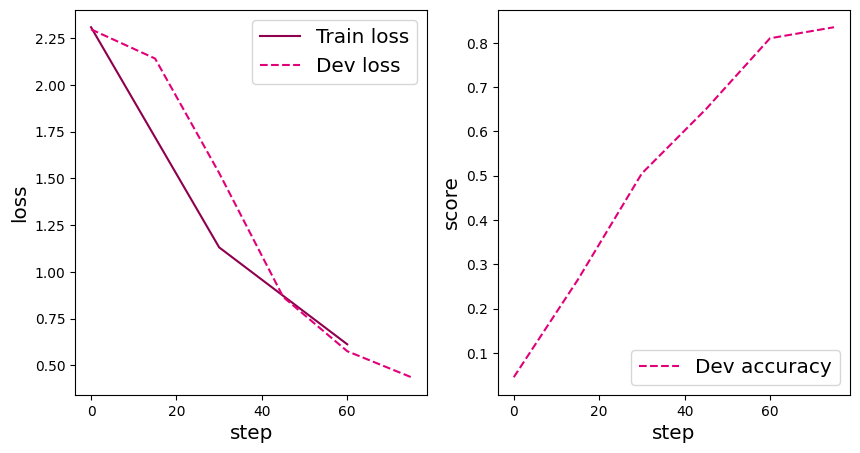

In [29]:
def plot(runner):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    train_items = runner.train_step_losses[::30]
    train_steps=[x[0] for x in train_items]
    train_losses = [x[1] for x in train_items]
    plt.plot(train_steps, train_losses, color='#8E004D', label="Train loss")
    if runner.dev_losses[0][0]!=-1:
        dev_steps=[x[0] for x in runner.dev_losses]
        dev_losses = [x[1] for x in runner.dev_losses]
        plt.plot(dev_steps, dev_losses, color='#E20079', linestyle='--', label="Dev loss")
    #绘制坐标轴和图例
    plt.ylabel("loss", fontsize='x-large')
    plt.xlabel("step", fontsize='x-large')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.subplot(1,2,2)
    #绘制评价准确率变化曲线
    if runner.dev_losses[0][0]!=-1:
        plt.plot(dev_steps, runner.dev_scores, 
            color='#E20079', linestyle="--", label="Dev accuracy")
    else:
        plt.plot(list(range(len(runner.dev_scores))), runner.dev_scores, 
            color='#E20079', linestyle="--", label="Dev accuracy")
    #绘制坐标轴和图例
    plt.ylabel("score", fontsize='x-large')
    plt.xlabel("step", fontsize='x-large')
    plt.legend(loc='lower right', fontsize='x-large')
    plt.show()

plot(runner)

In [ ]:
runner.load_model("./checkpoint/model_best.pdparams")
X, label = next(test_loader())
logits = runner.predict(X)
pred = F.softmax(logits)
pred_class = paddle.argmax(pred[1]).numpy()
label = label[1][0].numpy()
print(label[0])
print(pred_class[0])